In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
import math

In [30]:
# 2d Point
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __add__(self, point):
        return Point(self.x + point.x, self.y + point.y)
    
    def __sub__(self, point):
        return Point(self.x - point.x, self.y - point.y)
    
    def __rmul__(self, other):
        return Point(self.x * other, self.y * other)
    
class Human :
    def __init__(self, location, speed, race, bias):
        self.location = location
        self.travelSpeed = speed
        self.race = race
        # bias against another race
        self.bias = bias
        
    def dist(self, other):
        return math.hypot(self.location.x - other.location.x, self.location.y - other.location.y)
        
    def move(self, xlims, ylims):
        vx = np.random.uniform(-1, 1)
        vy = np.random.uniform(-1, 1)
        v = Point(vx, vy)
        self.location = self.location + self.travelSpeed * v
        if self.location.x < xlims[0]:
            self.location.x += (xlims[1] - xlims[0])
        if self.location.x >= xlims[1]:
            self.location.x -= (xlims[1] - xlims[0])
        if self.location.y < ylims[0]:
            self.location.y += (ylims[1] - ylims[0])
        if self.location.y >= ylims[1]:
            self.location.y -= (ylims[1] - ylims[0])
        

class Population :
    def __init__(self, numMembers, race, biasMean, biasVariance, xlims, ylims):
        self.race = race
        self.mean = biasMean
        self.variance = biasVariance
        self.members = []
        self.xlims = xlims
        self.ylims = ylims
        biases = np.random.normal(self.mean, self.variance, numMembers)
        for i in range(numMembers):
            rx = np.random.uniform(xlims[0], xlims[1])
            ry = np.random.uniform(ylims[0], ylims[1])
            member = Human(Point(rx, ry), 0.01, race, biases[i])
            self.members.append(member)
            
    def reEvaluateBias(self):
        values = [x.bias for x in self.members]
        self.mean = np.mean(values)
        self.variance = np.std(values, ddof=1)
        
    def count(self):
        return len(self.members)
    
    def move(self):
        for m in self.members:
            m.move(xlims, ylims)
    
# Simulation is carried out by evaluating 'meetings', where 2 or more Humans meet.
# Race A and Race B
# bias_A_i = bA_i
# average_group_bias_A = bA^
# average_group_bias_AB = bAB^


# Situation 0
# if group A = 1 member meets group B = 1 member
# bA_1 = bB_1 = bAB^

# Situation 1
# if group A = 1 member meets group B = n members
# if bB^ > mu + 3 * sigma, group A is eliminated
# if bB^ < mu - 3 * sigma, bA_1 /= n
# all other cases bA_1 += (bB^ - bA^)

# Situation 2
# if group A = n members meets group B = m members
# WLOG if bA^ < bB^
# bA_i += (bB^ - bA^)
# bB_i -= (bB^ - bA^)

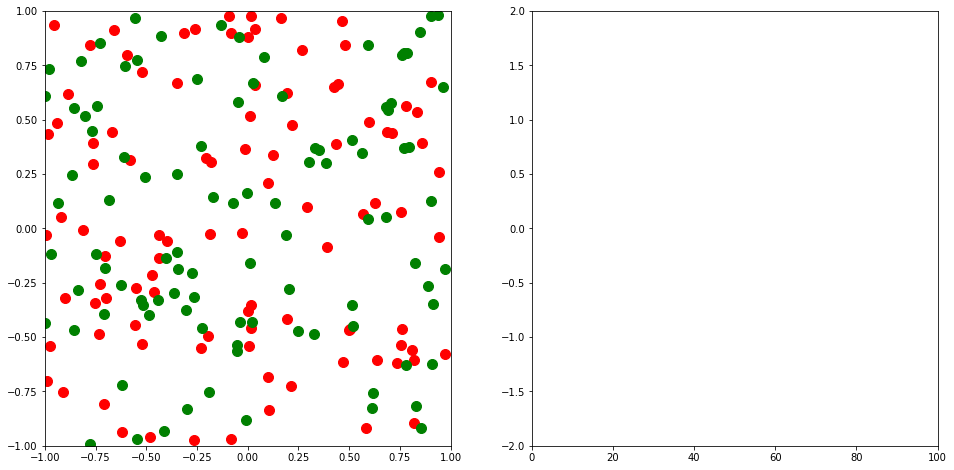

In [71]:
xlims = (-1, 1)
ylims = (-1, 1)
iterations = 100
####
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
ax1.set_xlim((xlims[0], xlims[1]))
ax1.set_ylim((ylims[0], ylims[1]))
membersA, = ax1.plot([],[], 'ro', markersize=10)
membersB, = ax1.plot([],[], 'go', markersize=10)
ax2.set_xlim((0, iterations))
ax2.set_ylim((-2, 2))
biasA, = ax2.plot([],[])
biasB, = ax2.plot([],[])

raceA = Population(100, 'Morlocks', 1, 0.5, xlims, ylims)
raceB = Population(100, 'Elves', 0, 0.5, xlims, ylims)

def interactSame(race, threshold):
    # bias increases towards average
    for i in range(len(race.members)):
        for j in range(i + 1, len(race.members)):
            p1 = race.members[i]
            p2 = race.members[j]
            if p1.dist(p2) < threshold :
                avgBias = (p1.bias + p2.bias) / 2
                if p1.bias < p2.bias :
                    p1.bias = avgBias
                else:
                    p2.bias = avgBias

def interactDifferent(raceA, raceB, threshold):
    # bias decreases towards average
    for p1 in raceA.members :
        for p2 in raceB.members:
            if p1.dist(p2) < threshold :
                avgBias = (p1.bias + p2.bias) / 2
                if p1.bias > p2.bias :
                    p1.bias = avgBias
                else:
                    p2.bias = avgBias

bA = []
bB = []
                    
def runSim(time):
    posA = [m.location for m in raceA.members]
    membersA.set_data([m.x for m in posA], [m.y for m in posA])
    posB = [m.location for m in raceB.members]
    membersB.set_data([m.x for m in posB], [m.y for m in posB])
    
    global bA
    global bB
    
    if time == 0:
        bA = []
        bB = []
    
    # move the population
    raceA.move()
    raceB.move()
    
    # interact
    threshold = 0.01
    interactDifferent(raceA, raceB, threshold)
    interactSame(raceA, threshold)
    interactSame(raceB, threshold)
    
    raceA.reEvaluateBias()
    raceB.reEvaluateBias()
    
    bA.append(raceA.mean)
    bB.append(raceB.mean)
    
    biasA.set_data(list(range(len(bA))), bA)
    biasB.set_data(list(range(len(bB))), bB)
    
    #print("Race A Bias {}".format(raceA.mean))
    #print("Race B Bias {}".format(raceB.mean))
    
ani = anim.FuncAnimation(fig, runSim, frames=iterations)

from IPython.display import HTML
HTML(ani.to_jshtml())  